In [1]:
import sparse
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import scipy as sp
import sys
import io
from tqdm import tqdm, trange
import pickle

import dice_ml
from dice_ml.utils import helpers
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('..')
from learn_distance.evaluate import *
from learn_distance.ordinal import *

In [7]:
problem = 'ARF_4h'
dataset = 'mimic3'

s = sparse.load_npz('../data/fiddle/FIDDLE_{dataset}/features/{problem}/s.npz'.format(problem=problem, dataset=dataset)).todense()
x = sparse.load_npz('../data/fiddle/FIDDLE_{dataset}/features/{problem}/X.npz'.format(problem=problem, dataset=dataset)).todense()

s_feats = json.load(open('../data/fiddle/FIDDLE_{dataset}/features/{problem}/s.feature_names.json'.format(problem=problem, dataset=dataset), 'r'))
x_feats = json.load(open('../data/fiddle/FIDDLE_{dataset}/features/{problem}/X.feature_names.json'.format(problem=problem, dataset=dataset), 'r'))

y = pd.read_csv('../data/fiddle/FIDDLE_{dataset}/population/{problem}.csv'.format(problem=problem, dataset=dataset))

In [8]:
end = x.shape[1]-1
d = x[:,end,:] - x[:,0,:]
x_start = np.hstack([s,x[:,0,:]])
x_end = np.hstack([s,x[:,end,:]])
feats = s_feats + x_feats

In [9]:
frequent = ['DiaBP', 'HR', 'SpO2', 'RR', 'SysBP']
stats = ['value', 'max', 'min', 'mean']
feat_idx, sets, freq_stats = get_feature_idx(
    frequent=frequent,
    stats=stats,
    x_feats=x_feats,
    s_feats=s_feats)

In [10]:
df_start = pd.DataFrame(ohe_to_ordinal(
    feature_sets=sets,
    feat_idx=feat_idx,
    x=x_start
))

df_end = pd.DataFrame(ohe_to_ordinal(
    feature_sets=sets,
    feat_idx=feat_idx,
    x=x_end
))

na_start = get_na_mask(x_start, freq_stats, feat_idx)
na_end = get_na_mask(x_end, freq_stats, feat_idx)

In [11]:
na_both = np.logical_and(na_start, na_end)

df_start = df_start.iloc[na_both,:]
df_end = df_end.iloc[na_both,:]

y_start = y['ARF_LABEL'][na_start]
y_end = y['ARF_LABEL'][na_end]
y_both = y['ARF_LABEL'][na_both]

In [12]:
xtr, xte, ytr, yte = train_test_split(df_start, y_both, stratify=y_both, random_state=123)
boundary = LogisticRegression(solver='liblinear', penalty='l1')
boundary.fit(xtr, ytr)

LogisticRegression(penalty='l1', solver='liblinear')

In [13]:
train = pd.DataFrame(xtr, columns = df_start.columns)
train['label'] = ytr

start = train.drop(columns=['label'])

test = pd.DataFrame(xte, columns=df_start.columns)
test['label'] = yte

In [10]:
coef_df = pd.DataFrame(
    {'feat' : df_start.columns,
    'coef' : boundary.coef_.flatten(),
    'abs_coef' : np.abs(boundary.coef_.flatten())})

coef_df.sort_values(by=['abs_coef'], ascending=False)[:20]

,feat,coef,abs_coef
763,225892_value,2.007265,2.007265
72,221794_value,-1.643968,1.643968
1299,70059_value,1.472543,1.472543
840,226363_value,1.348916,1.348916
851,226375_value,-1.316432,1.316432
496,224974_value,1.213806,1.213806
1307,70088_value,1.197444,1.197444
346,224369_value,-1.191040,1.191040
654,225439_value,1.134404,1.134404
417,224801_value,-1.125684,1.125684


In [11]:
hundred = train.iloc[:100,:]
m = dice_ml.Model(model=boundary, backend="sklearn")
d = dice_ml.Data(dataframe=train, continuous_features=freq_stats, outcome_name='label')
exp = dice_ml.Dice(d, m, method="random")

In [14]:
pos = np.where(yte==1)
diff = df_end - df_start

In [13]:
def compare_cf(d, diff, mad, ftv, tol=1e-5, n_avg=5):
   d = d[ftv]
   comp = diff[ftv]
   distance = []
   for i in range(comp.shape[0]):
      distance.append(np.sum(np.abs(d - comp.iloc[i,:])/(mad+tol)))
   distance = np.sort(distance)
   return np.sum(distance[:n_avg])/n_avg

In [14]:
def evaluate_rank(df, model, diff, ftv, cont=[], n_cfs=3, n_avg=5):
    m = dice_ml.Model(model=model, backend="sklearn")
    d = dice_ml.Data(dataframe=df, continuous_features=cont, outcome_name='label')
    exp = dice_ml.Dice(d, m, method="random")
    all_comparisons = []
    top_comparisons = []
    top_cfs = []
    bot_cfs = []
    failed = []
    few = []
    few_cfs = []
    changes = pd.DataFrame(columns = ['idx', 'cf_idx'] + ftv)
    mad = sp.stats.median_abs_deviation(diff[ftv])
    for i in trange(df.shape[0]):
        query = df.iloc[i:(i+1),:]
        query = query.drop(columns=['label'])
        try:
            e = exp.generate_counterfactuals(
                query,
                total_CFs=n_cfs, 
                desired_class="opposite",
                features_to_vary=ftv)
        except:
            failed.append(i)
            continue
        cfs = e.cf_examples_list[0].final_cfs_df
        if cfs is None:
            failed.append(i)
            continue
        elif cfs.shape[0] < n_cfs:
            few.append(i)
            few_cfs.append(cfs)
            continue
        comparisons = []
        for j in trange(n_cfs):
            d = cfs.iloc[j,:-1].apply(pd.to_numeric) - query.iloc[0,:].apply(pd.to_numeric)
            c = compare_cf(
                d=d,
                diff=diff,
                mad=mad,
                ftv=ftv
            )
            row = []
            changes.loc[len(changes)] = [int(i), int(j)] + list(np.zeros(len(ftv)))
            changes.iloc[i,:][ftv] = d[ftv]
            all_comparisons.append(c)
            comparisons.append(c)
        top = np.argmin(comparisons)
        bot = np.argmax(comparisons)
        top_comparisons.append(comparisons[top])

        top_cfs.append(cfs.iloc[top,:])
        bot_cfs.append(cfs.iloc[bot,:])
    results = {
        'all' : all_comparisons,
        'top' : top_comparisons,
        'top_cfs' : top_cfs,
        'bot_cfs' : bot_cfs,
        'failed' : failed,
        'few' : few,
        'few_cfs' : few_cfs,
        'changes' : changes
    }
    return results

In [15]:
test_pos = test.iloc[pos]
test_pos[freq_stats] = test_pos[freq_stats].apply(pd.to_numeric)

/tmp/ipykernel_1651731/3042171672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pos[freq_stats] = test_pos[freq_stats].apply(pd.to_numeric)


In [16]:
eval_df = test_pos
results = evaluate_rank(
    df = eval_df,
    model = boundary,
    diff = diff,
    n_cfs=10,
    n_avg=3,
    ftv = freq_stats,
    cont = freq_stats
)

100%|██████████| 1/1 [00:04<00:00,  4.02s/it]

  1%|          | 2/276 [00:34<1:08:15, 14.95s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



  1%|          | 3/276 [00:38<45:48, 10.07s/it]  

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.13s/it]

100%|██████████| 1/1 [00:04<00:00,  4.00s/it]

  2%|▏         | 6/276 [01:43<1:13:12, 16.27s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.11s/it]

100%|██████████| 1/1 [00:04<00:00,  4.21s/it]

  3%|▎         | 9/276 [02:48<1:18:48, 17.71s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.26s/it]

  4%|▍         | 11/276 [03:22<1:11:56, 16.29s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



  4%|▍         | 12/276 [03:27<55:33, 12.63s/it]  

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.13s/it]

100%|██████████| 1/1 [00:04<00:00,  4.01s/it]

  5%|▌         | 15/276 [04:31<1:11:15, 16.38s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



  6%|▌         | 16/276 [04:36<55:56, 12.91s/it]  

Only 4 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.82s/it]

100%|██████████| 1/1 [00:05<00:00,  5.57s/it]

  7%|▋         | 19/276 [05:43<1:12:41, 16.97s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.01s/it]

100%|██████████| 1/1 [00:04<00:00,  4.00s/it]

100%|██████████| 1/1 [00:05<00:00,  5.51s/it]

  8%|▊         | 23/276 [07:21<1:23:55, 19.90s/it]

Only 5 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 05 sec



100%|██████████| 1/1 [00:05<00:00,  5.09s/it]

100%|██████████| 1/1 [00:04<00:00,  4.02s/it]

100%|██████████| 1/1 [00:04<00:00,  4.50s/it]

100%|██████████| 1/1 [00:04<00:00,  4.08s/it]

100%|██████████| 1/1 [00:04<00:00,  4.54s/it]

 11%|█         | 29/276 [09:59<1:28:37, 21.53s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.51s/it]

100%|██████████| 1/1 [00:04<00:00,  4.68s/it]

100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

100%|██████████| 1/1 [00:04<00:00,  4.51s/it]

100%|██████████| 1/1 [00:04<00:00,  4.91s/it]

 13%|█▎        | 35/276 [12:36<1:27:15, 21.72s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.51s/it]

100%|██████████| 1/1 [00:04<00:00,  4.37s/it]

100%|██████████| 1/1 [00:03<00:00,  3.97s/it]

 14%|█▍        | 39/276 [14:13<1:22:12, 20.81s/it]

Only 5 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 05 sec



100%|██████████| 1/1 [00:04<00:00,  4.42s/it]

100%|██████████| 1/1 [00:05<00:00,  5.05s/it]

 15%|█▌        | 42/276 [15:19<1:15:51, 19.45s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

100%|██████████| 1/1 [00:04<00:00,  4.14s/it]

100%|██████████| 1/1 [00:04<00:00,  4.58s/it]

100%|██████████| 1/1 [00:05<00:00,  5.82s/it]

 17%|█▋        | 47/276 [17:27<1:21:40, 21.40s/it]

Only 4 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 05 sec



100%|██████████| 1/1 [00:04<00:00,  4.10s/it]

 18%|█▊        | 49/276 [18:02<1:09:09, 18.28s/it]

Only 2 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 18%|█▊        | 50/276 [18:07<53:41, 14.25s/it]  

Only 4 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.11s/it]

100%|██████████| 1/1 [00:04<00:00,  4.48s/it]

 19%|█▉        | 53/276 [19:13<1:03:35, 17.11s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.47s/it]

100%|██████████| 1/1 [00:03<00:00,  3.99s/it]

 20%|██        | 56/276 [20:18<1:06:04, 18.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.47s/it]

 21%|██        | 58/276 [20:53<1:00:40, 16.70s/it]

Only 2 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:05<00:00,  5.63s/it]

100%|██████████| 1/1 [00:04<00:00,  4.26s/it]

100%|██████████| 1/1 [00:05<00:00,  5.23s/it]

100%|██████████| 1/1 [00:04<00:00,  4.02s/it]

 23%|██▎       | 63/276 [23:02<1:13:33, 20.72s/it]

Only 6 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.02s/it]

 24%|██▎       | 65/276 [23:37<1:02:35, 17.80s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.12s/it]

100%|██████████| 1/1 [00:04<00:00,  4.16s/it]

100%|██████████| 1/1 [00:04<00:00,  4.02s/it]

 25%|██▌       | 69/276 [25:12<1:07:47, 19.65s/it]

Only 3 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 25%|██▌       | 70/276 [25:17<51:37, 15.04s/it]  

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.50s/it]

100%|██████████| 1/1 [00:04<00:00,  4.30s/it]

100%|██████████| 1/1 [00:05<00:00,  5.44s/it]

100%|██████████| 1/1 [00:04<00:00,  4.13s/it]

100%|██████████| 1/1 [00:04<00:00,  4.39s/it]

100%|██████████| 1/1 [00:05<00:00,  5.06s/it]

100%|██████████| 1/1 [00:04<00:00,  4.56s/it]

 28%|██▊       | 78/276 [28:56<1:12:33, 21.99s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.02s/it]

100%|██████████| 1/1 [00:04<00:00,  4.18s/it]

100%|██████████| 1/1 [00:04<00:00,  4.33s/it]

100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

100%|██████████| 1/1 [00:04<00:00,  4.60s/it]

 30%|███       | 84/276 [31:33<1:09:28, 21.71s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 31%|███       | 85/276 [31:38<52:27, 16.48s/it]  

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.33s/it]

 32%|███▏      | 87/276 [32:12<49:36, 15.75s/it]  

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:05<00:00,  5.10s/it]

100%|██████████| 1/1 [00:04<00:00,  4.84s/it]

100%|██████████| 1/1 [00:04<00:00,  4.19s/it]

 33%|███▎      | 91/276 [33:49<59:11, 19.20s/it]  

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 33%|███▎      | 92/276 [33:54<45:16, 14.77s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.75s/it]

 34%|███▍      | 94/276 [34:29<46:05, 15.20s/it]

Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

 35%|███▍      | 96/276 [35:04<45:26, 15.15s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.01s/it]

100%|██████████| 1/1 [00:04<00:00,  4.17s/it]

 36%|███▌      | 99/276 [36:09<51:08, 17.34s/it]  

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.20s/it]

 37%|███▋      | 101/276 [36:44<47:18, 16.22s/it]  

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 37%|███▋      | 102/276 [36:49<36:40, 12.65s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.22s/it]

 38%|███▊      | 104/276 [37:23<39:52, 13.91s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 38%|███▊      | 105/276 [37:28<31:25, 11.03s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.04s/it]

 39%|███▉      | 107/276 [38:02<36:45, 13.05s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.68s/it]

100%|██████████| 1/1 [00:04<00:00,  4.17s/it]

 40%|███▉      | 110/276 [39:08<46:09, 16.69s/it]  

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

 41%|████      | 112/276 [39:43<43:19, 15.85s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

100%|██████████| 1/1 [00:04<00:00,  4.64s/it]

 42%|████▏     | 115/276 [40:48<47:33, 17.73s/it]  

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.01s/it]

100%|██████████| 1/1 [00:04<00:00,  4.61s/it]

 43%|████▎     | 118/276 [41:54<48:06, 18.27s/it]  

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 43%|████▎     | 119/276 [41:58<36:50, 14.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 43%|████▎     | 120/276 [42:02<28:58, 11.15s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 44%|████▍     | 121/276 [42:07<23:29,  9.09s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 44%|████▍     | 122/276 [42:11<19:48,  7.72s/it]

Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.73s/it]

100%|██████████| 1/1 [00:04<00:00,  4.16s/it]

100%|██████████| 1/1 [00:04<00:00,  4.11s/it]

 46%|████▌     | 126/276 [43:47<43:00, 17.20s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 46%|████▌     | 127/276 [43:52<33:32, 13.51s/it]

Only 3 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:05<00:00,  5.57s/it]

100%|██████████| 1/1 [00:05<00:00,  5.07s/it]

 47%|████▋     | 130/276 [45:00<42:02, 17.28s/it]

Only 3 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 47%|████▋     | 131/276 [45:04<32:19, 13.38s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.45s/it]

100%|██████████| 1/1 [00:04<00:00,  4.04s/it]

 49%|████▊     | 134/276 [46:10<39:41, 16.77s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.31s/it]

100%|██████████| 1/1 [00:04<00:00,  4.49s/it]

100%|██████████| 1/1 [00:05<00:00,  5.15s/it]

100%|██████████| 1/1 [00:04<00:00,  4.06s/it]

 50%|█████     | 139/276 [48:17<46:56, 20.55s/it]  

Only 3 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 51%|█████     | 140/276 [48:22<35:30, 15.67s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 51%|█████     | 141/276 [48:26<27:34, 12.25s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 51%|█████▏    | 142/276 [48:30<22:01,  9.87s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:05<00:00,  5.20s/it]

100%|██████████| 1/1 [00:04<00:00,  4.05s/it]

100%|██████████| 1/1 [00:04<00:00,  4.44s/it]

100%|██████████| 1/1 [00:04<00:00,  4.15s/it]

100%|██████████| 1/1 [00:04<00:00,  4.06s/it]

100%|██████████| 1/1 [00:04<00:00,  4.58s/it]

 54%|█████▍    | 149/276 [51:38<44:27, 21.01s/it]  

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.73s/it]

100%|██████████| 1/1 [00:04<00:00,  4.17s/it]

 55%|█████▌    | 152/276 [52:45<40:33, 19.62s/it]

Only 2 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 55%|█████▌    | 153/276 [52:49<30:47, 15.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.19s/it]

100%|██████████| 1/1 [00:04<00:00,  4.18s/it]

100%|██████████| 1/1 [00:04<00:00,  4.08s/it]

100%|██████████| 1/1 [00:04<00:00,  4.15s/it]

100%|██████████| 1/1 [00:04<00:00,  4.01s/it]

 58%|█████▊    | 159/276 [55:26<40:32, 20.79s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:05<00:00,  5.12s/it]

100%|██████████| 1/1 [00:04<00:00,  4.04s/it]

100%|██████████| 1/1 [00:04<00:00,  4.79s/it]

 59%|█████▉    | 163/276 [57:04<39:04, 20.75s/it]

Only 5 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 05 sec



100%|██████████| 1/1 [00:04<00:00,  4.18s/it]

100%|██████████| 1/1 [00:04<00:00,  4.32s/it]

 60%|██████    | 166/276 [58:09<35:23, 19.30s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.59s/it]

100%|██████████| 1/1 [00:04<00:00,  4.35s/it]

 61%|██████    | 169/276 [59:15<33:41, 18.89s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.59s/it]

100%|██████████| 1/1 [00:04<00:00,  4.31s/it]

100%|██████████| 1/1 [00:04<00:00,  4.84s/it]

100%|██████████| 1/1 [00:03<00:00,  4.00s/it]

100%|██████████| 1/1 [00:04<00:00,  4.40s/it]

100%|██████████| 1/1 [00:04<00:00,  4.49s/it]

100%|██████████| 1/1 [00:04<00:00,  4.04s/it]

 64%|██████▍   | 177/276 [1:02:54<36:24, 22.07s/it]

Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:05<00:00,  5.04s/it]

 65%|██████▍   | 179/276 [1:03:29<30:09, 18.66s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.17s/it]

 66%|██████▌   | 181/276 [1:04:04<26:36, 16.81s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.04s/it]

100%|██████████| 1/1 [00:04<00:00,  4.89s/it]

 67%|██████▋   | 184/276 [1:05:09<27:31, 17.95s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.13s/it]

100%|██████████| 1/1 [00:04<00:00,  4.14s/it]

 70%|███████   | 194/276 [1:07:37<23:12, 16.98s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 71%|███████   | 195/276 [1:07:41<17:46, 13.16s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.28s/it]

100%|██████████| 1/1 [00:04<00:00,  4.30s/it]

100%|██████████| 1/1 [00:04<00:00,  4.72s/it]

100%|██████████| 1/1 [00:04<00:00,  4.13s/it]

100%|██████████| 1/1 [00:04<00:00,  4.01s/it]

100%|██████████| 1/1 [00:05<00:00,  5.13s/it]

100%|██████████| 1/1 [00:04<00:00,  4.14s/it]

 74%|███████▎  | 203/276 [1:11:18<26:15, 21.58s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.05s/it]

100%|██████████| 1/1 [00:04<00:00,  4.62s/it]

 75%|███████▍  | 206/276 [1:12:24<23:11, 19.88s/it]

Only 3 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 05 sec



 75%|███████▌  | 207/276 [1:12:29<17:41, 15.39s/it]

Only 6 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.13s/it]

100%|██████████| 1/1 [00:04<00:00,  4.40s/it]

100%|██████████| 1/1 [00:04<00:00,  4.61s/it]

 76%|███████▋  | 211/276 [1:14:05<20:37, 19.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 77%|███████▋  | 212/276 [1:14:10<15:37, 14.65s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.18s/it]

100%|██████████| 1/1 [00:04<00:00,  4.04s/it]

 78%|███████▊  | 215/276 [1:15:16<17:49, 17.54s/it]

Only 4 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 05 sec



 78%|███████▊  | 216/276 [1:15:20<13:34, 13.57s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 79%|███████▊  | 217/276 [1:15:25<10:44, 10.93s/it]

Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.05s/it]

 79%|███████▉  | 219/276 [1:16:01<12:51, 13.53s/it]

Only 9 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 06 sec



100%|██████████| 1/1 [00:05<00:00,  5.02s/it]

100%|██████████| 1/1 [00:04<00:00,  4.53s/it]

100%|██████████| 1/1 [00:04<00:00,  4.06s/it]

100%|██████████| 1/1 [00:04<00:00,  4.17s/it]

100%|██████████| 1/1 [00:04<00:00,  4.60s/it]

100%|██████████| 1/1 [00:05<00:00,  5.38s/it]

 82%|████████▏ | 226/276 [1:19:13<18:26, 22.12s/it]

Only 8 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 06 sec



100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

100%|██████████| 1/1 [00:03<00:00,  4.00s/it]

100%|██████████| 1/1 [00:04<00:00,  4.05s/it]

100%|██████████| 1/1 [00:04<00:00,  4.17s/it]

100%|██████████| 1/1 [00:04<00:00,  4.44s/it]

100%|██████████| 1/1 [00:04<00:00,  4.05s/it]

100%|██████████| 1/1 [00:04<00:00,  4.05s/it]

100%|██████████| 1/1 [00:04<00:00,  4.05s/it]

 85%|████████▌ | 235/276 [1:23:20<15:11, 22.23s/it]

Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.14s/it]

 86%|████████▌ | 237/276 [1:23:55<12:04, 18.58s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 86%|████████▌ | 238/276 [1:23:59<09:03, 14.29s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:05<00:00,  5.38s/it]

100%|██████████| 1/1 [00:04<00:00,  4.43s/it]

 87%|████████▋ | 241/276 [1:25:06<10:05, 17.29s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.07s/it]

100%|██████████| 1/1 [00:04<00:00,  4.15s/it]

 88%|████████▊ | 244/276 [1:26:10<09:36, 18.00s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.89s/it]

100%|██████████| 1/1 [00:04<00:00,  4.84s/it]

 89%|████████▉ | 247/276 [1:27:18<09:04, 18.77s/it]

Only 4 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 90%|████████▉ | 248/276 [1:27:22<06:43, 14.42s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 90%|█████████ | 249/276 [1:27:27<05:11, 11.55s/it]

Only 2 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.01s/it]

100%|██████████| 1/1 [00:05<00:00,  5.25s/it]

 91%|█████████▏| 252/276 [1:28:33<06:32, 16.34s/it]

Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.28s/it]

 92%|█████████▏| 254/276 [1:29:07<05:45, 15.69s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.13s/it]

100%|██████████| 1/1 [00:04<00:00,  4.16s/it]

 93%|█████████▎| 257/276 [1:30:12<05:32, 17.52s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.88s/it]

 94%|█████████▍| 259/276 [1:30:48<04:38, 16.41s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.19s/it]

 95%|█████████▍| 261/276 [1:31:23<03:57, 15.82s/it]

Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:05<00:00,  5.08s/it]

100%|██████████| 1/1 [00:04<00:00,  4.29s/it]

100%|██████████| 1/1 [00:04<00:00,  4.06s/it]

 96%|█████████▌| 265/276 [1:33:00<03:31, 19.24s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

100%|██████████| 1/1 [00:04<00:00,  4.09s/it]

100%|██████████| 1/1 [00:04<00:00,  4.63s/it]

 97%|█████████▋| 269/276 [1:34:37<02:21, 20.21s/it]

Only 4 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 05 sec



 98%|█████████▊| 270/276 [1:34:41<01:32, 15.43s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 98%|█████████▊| 271/276 [1:34:46<01:01, 12.37s/it]

Only 5 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 05 sec



 99%|█████████▊| 272/276 [1:34:51<00:40, 10.02s/it]

Only 2 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



 99%|█████████▉| 273/276 [1:34:55<00:25,  8.45s/it]

Only 2 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec



100%|██████████| 1/1 [00:04<00:00,  4.51s/it]

100%|██████████| 1/1 [00:04<00:00,  4.09s/it]

100%|██████████| 1/1 [00:04<00:00,  4.87s/it]

100%|██████████| 276/276 [1:36:28<00:00, 20.97s/it]


In [17]:
'''
output = open('results.pkl', 'wb')
pickle.dump(results, output)
output.close()
'''

In [3]:
with open('results.pkl', 'rb') as file:
    results = pickle.load(file)

In [4]:
results

{'all': [2.9999700002999967,
  3.7999620003799963,
  4.999950000499995,
  3.9999600003999958,
  6.399936000639992,
  140013.99986000138,
  280010.399896001,
  3.3999660003399965,
  100011.39988600112,
  1.9999800001999979,
  20020.79979200208,
  80026.39973600261,
  80025.99974000257,
  2.9999700002999967,
  2.799972000279997,
  80026.39973600261,
  2.599974000259997,
  80026.39973600261,
  3.9999600003999958,
  20019.799802001977,
  4.599954000459995,
  3.9999600003999958,
  300002.79997200024,
  100004.1999580004,
  100004.39995600042,
  100004.79995200047,
  1.5999840001599983,
  3.1999680003199966,
  5.399946000539994,
  17.599824001759977,
  10.799892001079987,
  80027.79972200275,
  160010.99989000108,
  20026.999730002695,
  13.799862001379983,
  8.79991200087999,
  21.199788002119977,
  13.799862001379983,
  10.399896001039988,
  140018.59981400182,
  80015.1998480015,
  80018.1998180018,
  80015.79984200155,
  13.999860001399984,
  100014.1998580014,
  80016.79983200166,
  800

In [29]:
np.sum(np.array(results['top'])>10000)/len(results['top'])

0.2988505747126437

In [5]:
print(np.average(results['all']))
np.average(results['top'])

109624.52639841416


23920.71941349551

In [16]:
moving = np.where(-np.all(results['changes'][['idx', 'cf_idx'] +freq_stats]==0, axis=0))
changing_vars = results['changes'][results['changes'].columns[moving]].drop(columns=['idx', 'cf_idx'])
changing_vars

,DiaBP_value,DiaBP_max,DiaBP_min,DiaBP_mean,HR_value,HR_max,HR_min,HR_mean,SpO2_value,SpO2_max,SpO2_min,SpO2_mean,RR_value,RR_max,RR_min,RR_mean,SysBP_value,SysBP_max,SysBP_min,SysBP_mean
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
unique_vals = {}
for i in range(changing_vars.shape[1]):
    unq = np.unique(changing_vars.iloc[:,i])
    unique_vals[changing_vars.columns[i]] = unq
unique_vals

{'DiaBP_value': array([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 'DiaBP_max': array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 'DiaBP_min': array([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 'DiaBP_mean': array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 'HR_value': array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 'HR_max': array([-4., -3., -2., -1.,  0.,  2.,  4.]),
 'HR_min': array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 'HR_mean': array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 'SpO2_value': array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 'SpO2_max': array([-3., -2., -1.,  0.,  1.,  3.]),
 'SpO2_min': array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 'SpO2_mean': array([-4., -1.,  0.,  1.,  2.,  3.,  4.]),
 'RR_value': array([-4., -3., -2., -1.,  0.,  1.,  2.,  4.]),
 'RR_max': array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 'RR_min': array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 'RR_mean': array([-4., -3., -2., -1.,  0.,  1.,  2.])

<Axes: >

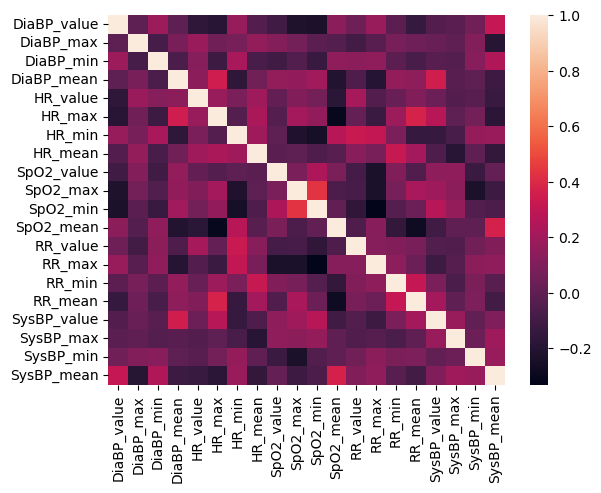

In [18]:
sns.heatmap(changing_vars.corr())

In [19]:
results['top']

[1.9999800001999979,
 2.599974000259997,
 1.5999840001599983,
 8.79991200087999,
 13.999860001399984,
 80015.1998480015,
 4.599954000459995,
 8.999910000899991,
 18.799812001879978,
 13.199868001319985,
 1.9999800001999979,
 4.399956000439995,
 16.79983200167998,
 80020.59979400205,
 20024.9997500025,
 11.599884001159987,
 5.7999420005799935,
 80025.79974200255,
 10.199898001019989,
 180021.99978000214,
 80025.39974600251,
 20023.9997600024,
 80012.99987000128,
 5.999940000599993,
 100012.79987200125,
 1.9999800001999979,
 9.19990800091999,
 80031.59968400314,
 7.9999200007999915,
 1.7999820001799982,
 22.399776002239975,
 100024.79975200244,
 2.1999780002199976,
 1.5999840001599983,
 16.599834001659982,
 80029.3997060029,
 80025.99974000257,
 7.9999200007999915,
 80025.39974600251,
 5.399946000539994,
 15.999840001599981,
 4.399956000439995,
 0.9999900000999989,
 20022.799772002276,
 180016.79983200165,
 5.999940000599993,
 11.399886001139986,
 180023.39976600232,
 26.199738002619974,

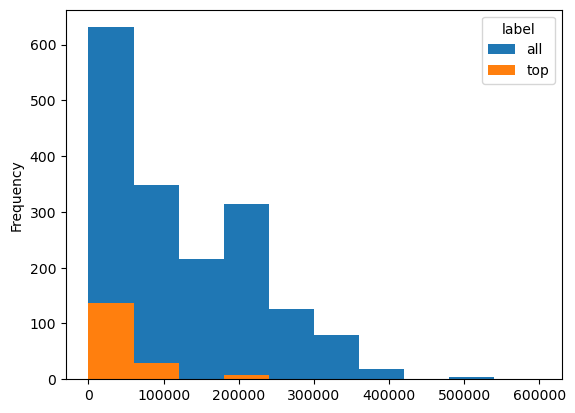

In [21]:
top_list = list(np.repeat('top', len(results['top'])))
all_list = list(np.repeat('all', len(results['all'])))
res_df = pd.DataFrame(
    {
        'label' : all_list + top_list,
        'distance' : results['all'] + results['top']  
    }
)
res_df.pivot(columns='label', values='distance').plot.hist()
plt.show()

In [133]:
y_tt = np.concatenate([ytr, yte])
pos_tt = np.where(y_tt == 1)[0]
diff_pos = diff.iloc[pos_tt]
change_cov = np.cov(diff_pos.T)
evals, evecs = np.linalg.eigh(change_cov)

In [225]:
evecs[:,-1]

array([ 0.01820459,  0.02202093,  0.00390191, ..., -0.00376135,
       -0.00238653,  0.01865682])

In [227]:
top_eig = np.where(np.abs(evecs[:,-1]) > np.quantile(np.abs(evecs[:,-1]), [0.98]))

In [229]:
diff.columns[top_eig]

Index(['223791_value', '223795_value', '223898_value', '223900_value',
       '223901_value', '223902_value', '223911_value', '223917_value',
       '223918_value', '223919_value', '223920_value', '223935_value',
       '223947_value', '223985_value', '223986_value', '223987_value',
       '223989_value', '223990_value', '224004_value', '224015_value',
       '224016_value', '224027_value', '224028_value', '224055_value',
       '224057_value', '224093_value', '224860_value'],
      dtype='object')

In [223]:
np.sum(np.square(evecs[:,0]))

0.9999999999999988

In [215]:
print(np.sum(evals))
evals[-10:]

650.8436338446704


array([ 13.28369838,  13.8250068 ,  15.55968421,  16.76592678,
        21.84595882,  23.78318955,  27.60716714,  29.3359182 ,
        31.73400066, 150.02882599])

In [216]:
y_tt = np.concatenate([ytr, yte])
pos_tt = np.where(y_tt == 1)[0]
diff_pos_freq = diff.iloc[pos_tt][freq_stats]
evals_f, evecs_f = np.linalg.eigh(np.cov(diff_pos_freq.T))

In [217]:
print(np.sum(evals_f))
evals_f[-10:]

32.52924296548104


array([0.34397759, 0.4700932 , 0.56584295, 0.66755084, 1.12676959,
       2.53333347, 2.99917451, 5.81977283, 7.5696769 , 8.72347922])

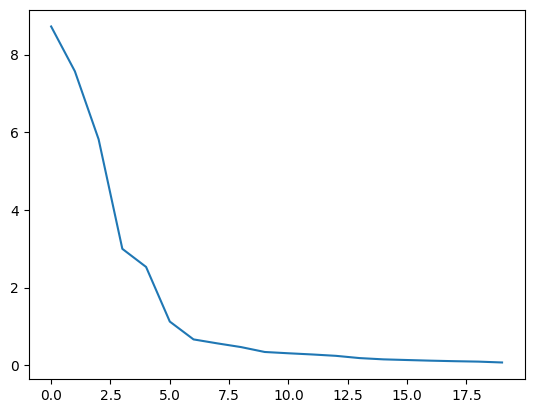

In [236]:
plt.plot(np.flip(evals_f))

In [238]:
evecs_f[:,-3]

array([ 0.19716742,  0.19981701,  0.18883417,  0.19995207, -0.05631526,
       -0.05696507, -0.05551583, -0.05798411, -0.13353981, -0.11466112,
       -0.10820223, -0.13848973, -0.41317689, -0.40362195, -0.36090884,
       -0.42251913,  0.17795755,  0.17342508,  0.18361855,  0.18156783])

In [237]:
freq_stats

['DiaBP_value',
 'DiaBP_max',
 'DiaBP_min',
 'DiaBP_mean',
 'HR_value',
 'HR_max',
 'HR_min',
 'HR_mean',
 'SpO2_value',
 'SpO2_max',
 'SpO2_min',
 'SpO2_mean',
 'RR_value',
 'RR_max',
 'RR_min',
 'RR_mean',
 'SysBP_value',
 'SysBP_max',
 'SysBP_min',
 'SysBP_mean']

In [232]:
top_eig = np.where(np.abs(evecs_f[:,-1]) > np.quantile(np.abs(evecs_f[:,-1]), [0.50]))
np.array(freq_stats)[top_eig]

array(['SysBP_mean'], dtype='<U11')

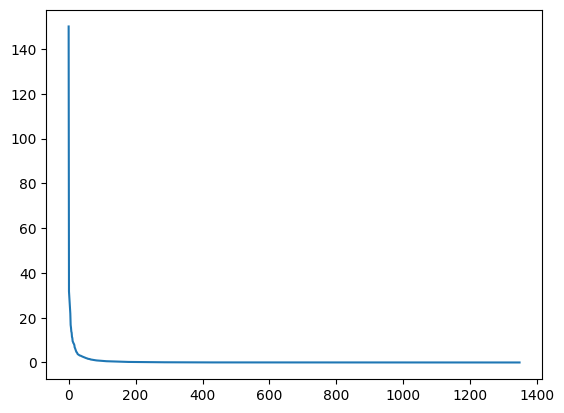

In [134]:
plt.plot(np.flip(evals))

<AxesSubplot:>

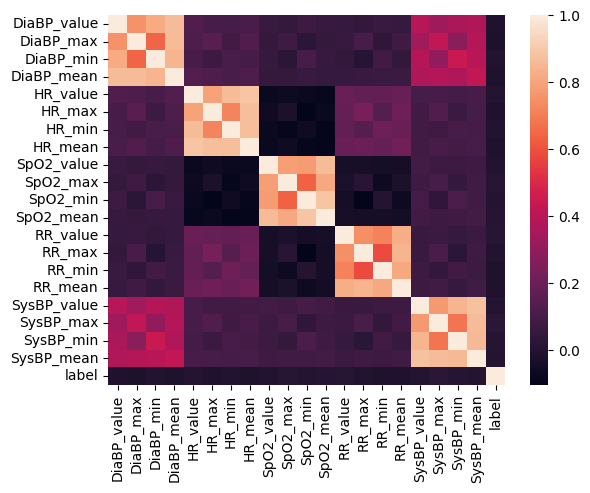

In [142]:
placeholder = diff.copy()
placeholder['label'] = y_tt
sns.heatmap(placeholder[freq_stats+['label']].corr())

<AxesSubplot:xlabel='label', ylabel='DiaBP_value'>

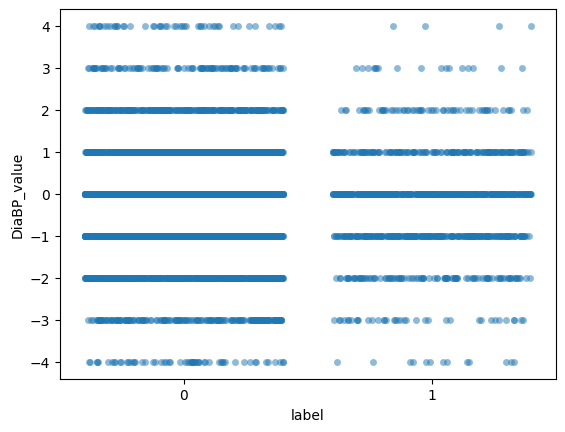

In [152]:
sns.stripplot(data=placeholder, y='DiaBP_value', x='label', jitter=0.4, alpha=0.5)